In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from chart_studio import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer


In [2]:
df = pd.read_csv('bank.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [6]:
print("Bank marketing dataset consists of {rows} rows.".format(rows = len(df)))

Bank marketing dataset consists of 11162 rows.


In [7]:
missing_values = df.isnull().mean()*100

missing_values.sum()

0.0

We see that there are no missing values

# Analysing the dataset - EDA

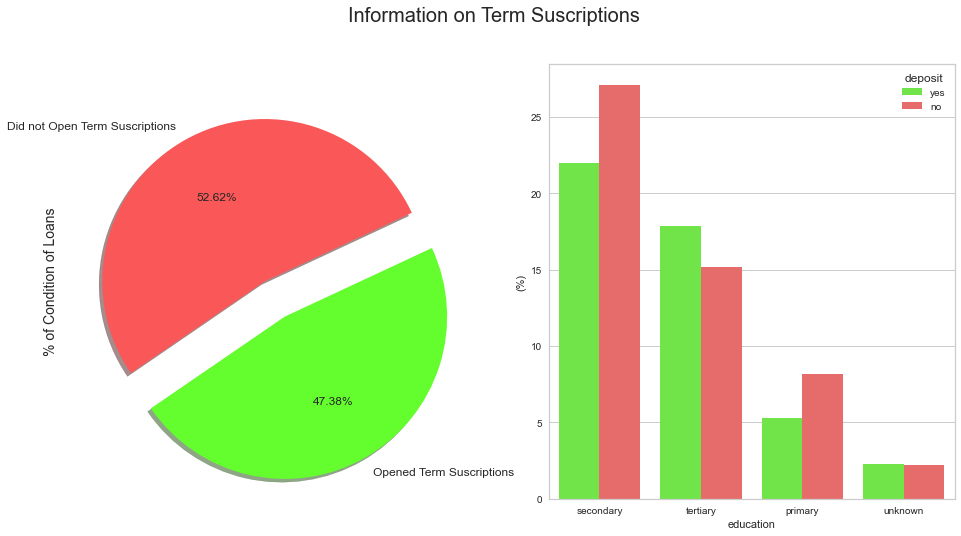

In [8]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#FA5858", "#64FE2E"]
labels ="Did not Open Term Suscriptions", "Opened Term Suscriptions"

plt.suptitle('Information on Term Suscriptions', fontsize=20)

df["deposit"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=25)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

palette = ["#64FE2E", "#FA5858"]

sns.barplot(x="education", y="balance", hue="deposit", data=df, palette=palette, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")
ax[1].set_xticklabels(df["education"].unique(), rotation=0, rotation_mode="anchor")
plt.show()

Analysis by Occupation:

1. Number of Occupations: Management is the occupation that is more prevalent in this dataset.
2. Age by Occupation: As expected, the retired are the ones who have the highest median age while student are the lowest.
3. Balance by Occupation: Management and Retirees are the ones who have the highest balance in their accounts.

In [9]:
df = df.drop(df.loc[df["job"] == "unknown"].index)

# Admin and management are basically the same let's put it under the same categorical value
lst = [df]

for col in lst:
    col.loc[col["job"] == "admin.", "job"] = "management"

In [10]:
import squarify
df = df.drop(df.loc[df["balance"] == 0].index)


x = 0
y = 0
width = 100
height = 100

job_names = df['job'].value_counts().index
values = df['job'].value_counts().tolist()

normed = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(normed, x, y, width, height)

colors = ['rgb(200, 255, 144)','rgb(135, 206, 235)',
          'rgb(235, 164, 135)','rgb(220, 208, 255)',
          'rgb(253, 253, 150)','rgb(255, 127, 80)', 
         'rgb(218, 156, 133)', 'rgb(245, 92, 76)',
         'rgb(252,64,68)', 'rgb(154,123,91)']

shapes = []
annotations = []
counter = 0

for r in rects:
    shapes.append(
        dict(
            type = 'rect',
            x0 = r['x'],
            y0 = r['y'],
            x1 = r['x'] + r['dx'],
            y1 = r['y'] + r['dy'],
            line = dict(width=2),
            fillcolor = colors[counter]
        )
    )
    annotations.append(
        dict(
            x = r['x']+(r['dx']/2),
            
            y = r['y']+(r['dy']/2),
            text = values[counter],
            showarrow = False
        )
    )
    counter = counter + 1
    if counter >= len(colors):
        counter = 0
    
# For hover text
trace0 = go.Scatter(
    x = [ r['x']+(r['dx']/2) for r in rects],
    y = [ r['y']+(r['dy']/2) for r in rects],
    text = [ str(v) for v in job_names],
    mode='text',
)
layout = dict(
    title='Number of Occupations <br> <i>(From our Sample Population)</i>',
    height=700, 
    width=700,
    xaxis=dict(showgrid=False,zeroline=False),
    yaxis=dict(showgrid=False,zeroline=False),
    shapes=shapes,
    annotations=annotations,
    hovermode='closest'
)

# With hovertext
figure = dict(data=[trace0], layout=layout)

iplot(figure, filename='squarify-treemap')

In [11]:
suscribed_df = df.loc[df["deposit"] == "yes"]

occupations = df["job"].unique().tolist()

# Get the balances by jobs
management = suscribed_df["age"].loc[suscribed_df["job"] == "management"].values
technician = suscribed_df["age"].loc[suscribed_df["job"] == "technician"].values
services = suscribed_df["age"].loc[suscribed_df["job"] == "services"].values
retired = suscribed_df["age"].loc[suscribed_df["job"] == "retired"].values
blue_collar = suscribed_df["age"].loc[suscribed_df["job"] == "blue-collar"].values
unemployed = suscribed_df["age"].loc[suscribed_df["job"] == "unemployed"].values
entrepreneur = suscribed_df["age"].loc[suscribed_df["job"] == "entrepreneur"].values
housemaid = suscribed_df["age"].loc[suscribed_df["job"] == "housemaid"].values
self_employed = suscribed_df["age"].loc[suscribed_df["job"] == "self-employed"].values
student = suscribed_df["age"].loc[suscribed_df["job"] == "student"].values

ages = [management, technician, services, retired, blue_collar, unemployed, 
         entrepreneur, housemaid, self_employed, student]

colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)',
          'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)',
         'rgba(229, 126, 56, 0.5)', 'rgba(229, 56, 56, 0.5)',
         'rgba(174, 229, 56, 0.5)', 'rgba(229, 56, 56, 0.5)']

traces = []

for xd, yd, cls in zip(occupations, ages, colors):
        traces.append(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker=dict(
                size=2,
            ),
            line=dict(width=1),
        ))

layout = go.Layout(
    title='Distribution of Ages by Occupation',
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(224,255,246)',
    plot_bgcolor='rgb(251,251,251)',
    showlegend=False
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig)

# Marital Status
Well in this analysis we didn't find any significant insights other than most divorced individuals are broke. No wonder since they have to split financial assets! Nevertheless, since no further insights have been found we will proceed to clustering marital status with education status. Let's see if we can find other groups of people in the sample population.

In [12]:
df['marital'].value_counts()

married     5815
single      3336
divorced    1174
Name: marital, dtype: int64

In [13]:
vals = df['marital'].value_counts().tolist()
labels = ['married', 'divorced', 'single']

data = [go.Bar(
            x=labels,
            y=vals,
    marker=dict(
    color="#FE9A2E")
    )]

layout = go.Layout(
    title="Count by Marital Status",
)

fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='basic-bar')

In [14]:
# Notice how divorced have a considerably low amount of balance.
fig = ff.create_facet_grid(
    df,
    x='duration',
    y='balance',
    color_name='marital',
    show_boxes=False,
    marker={'size': 10, 'opacity': 1.0},
    colormap={'single': 'rgb(165, 242, 242)', 'married': 'rgb(253, 174, 216)', 'divorced': 'rgba(201, 109, 59, 0.82)'}
)

iplot(fig, filename='facet - custom colormap')

In [15]:
cat_cols = []
for i in df.columns:
    if df[i].dtype == 'object':
        cat_cols.append(i)
       
print(cat_cols)
#categorical

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


In [16]:
# nummerical columns 

num_cols = []

for i in df.columns:
    if df[i].dtype == 'int64':
        num_cols.append(i)
        
print(num_cols)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


# Categorical columns exploration

In [17]:
# unique values in cat_cols:

for i in cat_cols:
    print(f'{ i.upper() }:{df[i].unique()}')
    print('\n')

JOB:['management' 'technician' 'services' 'retired' 'blue-collar' 'unemployed'
 'entrepreneur' 'housemaid' 'self-employed' 'student']


MARITAL:['married' 'divorced' 'single']


EDUCATION:['secondary' 'tertiary' 'primary' 'unknown']


DEFAULT:['no' 'yes']


HOUSING:['yes' 'no']


LOAN:['no' 'yes']


CONTACT:['unknown' 'cellular' 'telephone']


MONTH:['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']


POUTCOME:['unknown' 'other' 'failure' 'success']


DEPOSIT:['yes' 'no']




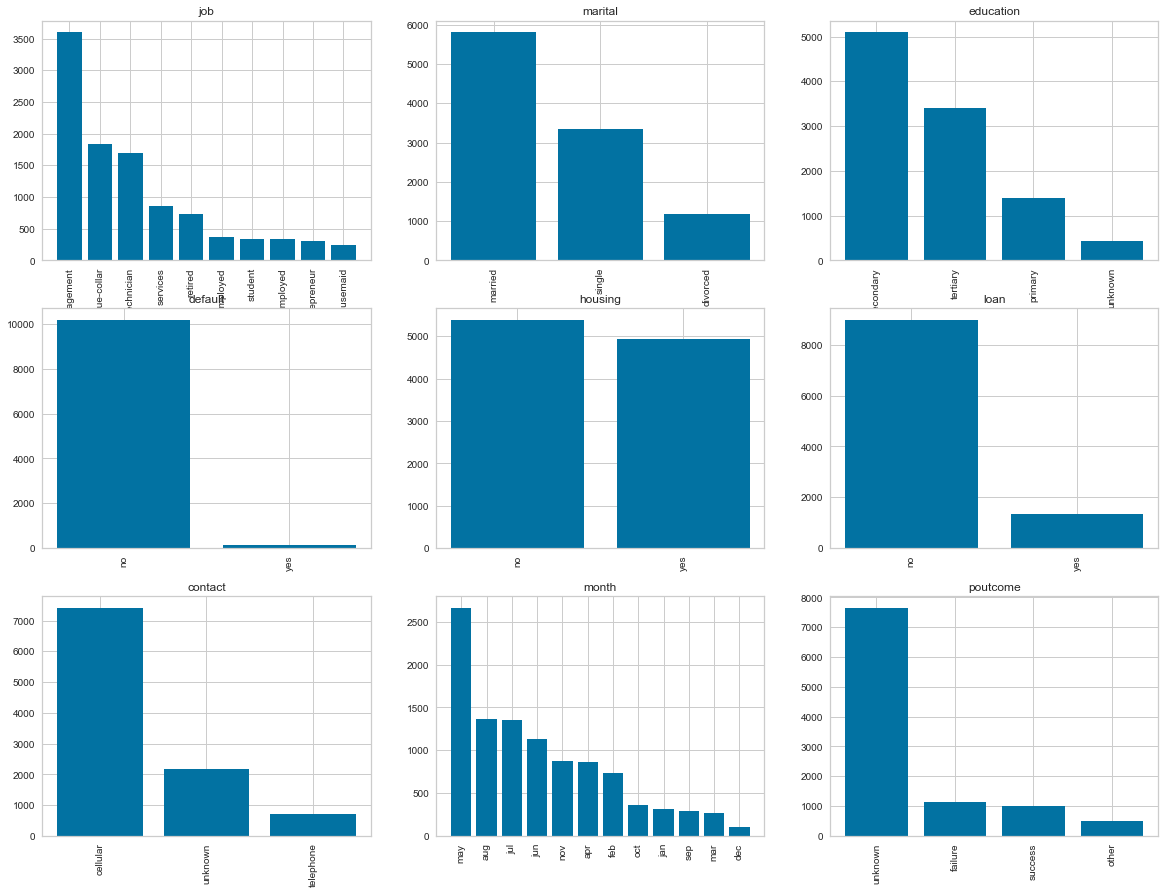

In [18]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()


# Numerical columns exploration

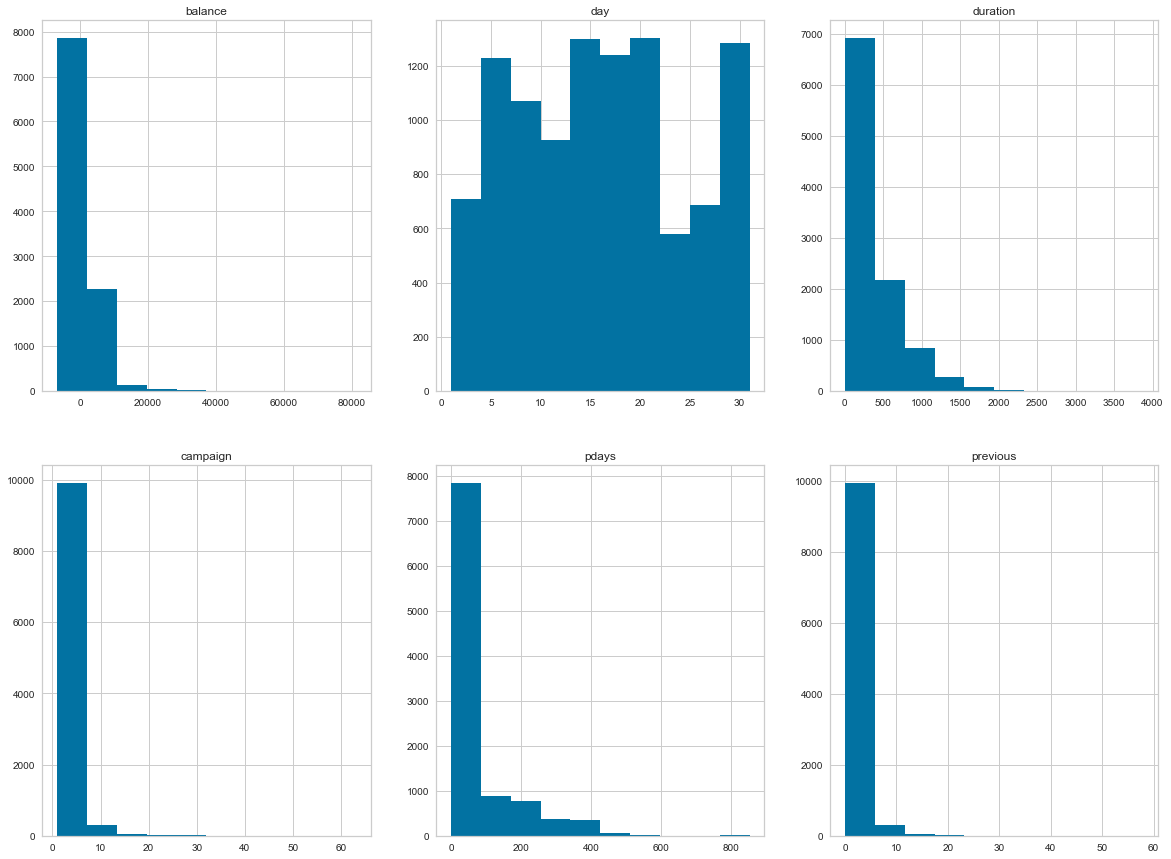

In [19]:
num_columns = ['balance', 'day','duration', 'campaign', 'pdays', 'previous']

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for num_column in num_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    axs[trace_x, trace_y].hist(df[num_column])
    
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1

plt.show()

We can see that numerical columns have outliers (especially 'pdays', 'campaign' and 'previous' columns). Possibly there are incorrect values (noisy data), so we should look closer at the data and decide how do we manage the noise.
Let's look closer at the values of 'campaign', 'pdays' and 'previous' columns:

In [20]:
df[['pdays', 'campaign', 'previous']].describe()

,pdays,campaign,previous
count,10325.000000,10325.000000,10325.000000
mean,52.207264,2.480291,0.846392
std,109.527621,2.656260,2.328262
min,-1.000000,1.000000,0.000000
25%,-1.000000,1.000000,0.000000
50%,-1.000000,2.000000,0.000000
75%,55.000000,3.000000,1.000000
max,854.000000,63.000000,58.000000


Percentage of 'pdays' values above 400:

In [21]:
len (df[df['pdays'] > 400] ) / len(df) * 100

1.2009685230024212

'pdays' holds the number of days that passed by after the client was last contacted from a previous campaign Looking closer into 'pdays' data we can see that:

only 1.2% of values above 400. 

They are possibly outliers, so we should consider imputing something (possibly mean value) instead of these values.

-1 possibly means that the client wasn't contacted before or stands for missing data.

Since we are not sure exactly what -1 means I suggest to drop this column, because -1 makes more than 50% of the values of the column.

# Percentage of 'campaign' values above 20:

In [22]:
len (df[df['campaign'] > 34] ) / len(df) * 100

0.029055690072639227

'campaign' holds the number of contacts performed during this campaign and for this client (numeric, includes last contact) Numbers for 'campaign' above 34 are clearly noise, so I suggest to impute them with average campaign values while data cleaning.

Percentage of 'previous' values above 20:

In [23]:
len (df[df['previous'] > 34] ) / len(df) * 100

0.048426150121065374

'previous' holds the number of contacts performed before this campaign and for this client (numeric) Numbers for 'previous' above 34 are also really strange, so I suggest to impute them with average campaign values while data cleaning.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



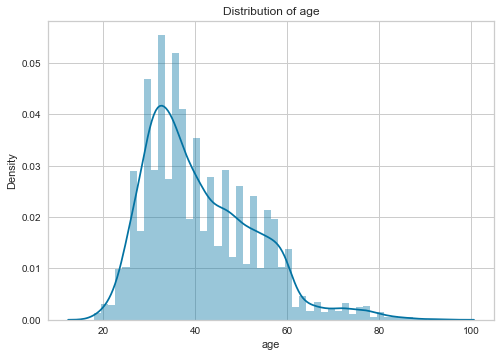

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



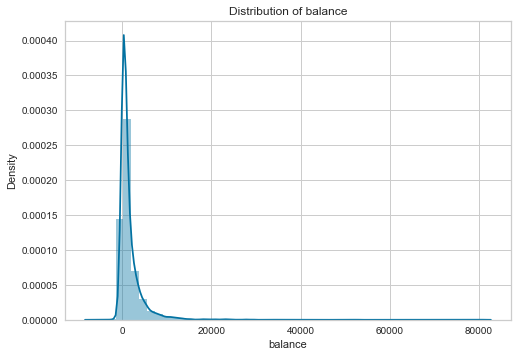

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



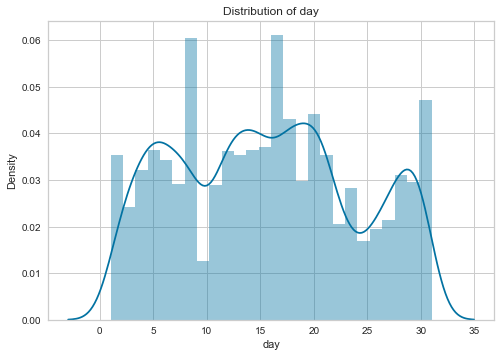

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



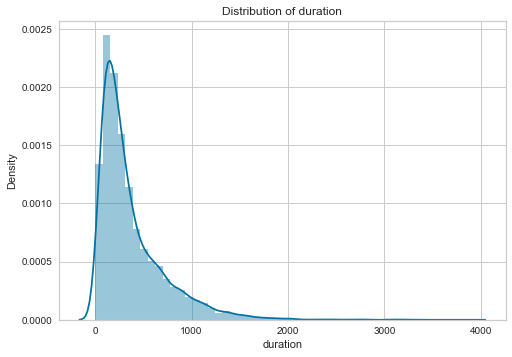

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



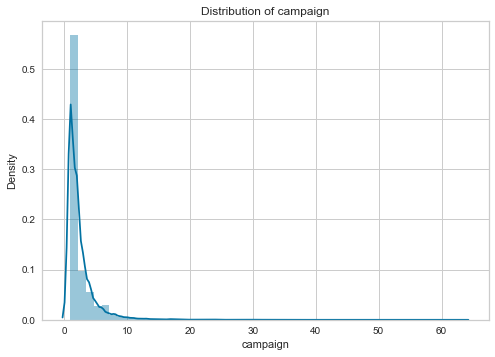

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



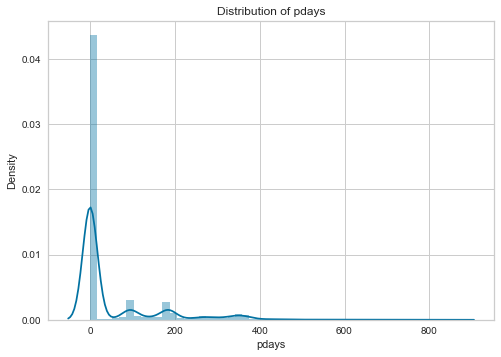

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



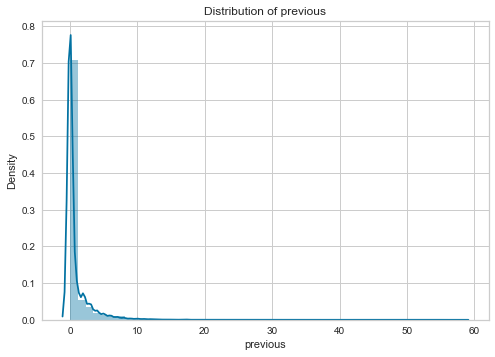

In [24]:
# distribution of continuous variables 

for i in num_cols:
    sns.distplot(df[i])
    plt.title(f'Distribution of {i}')
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



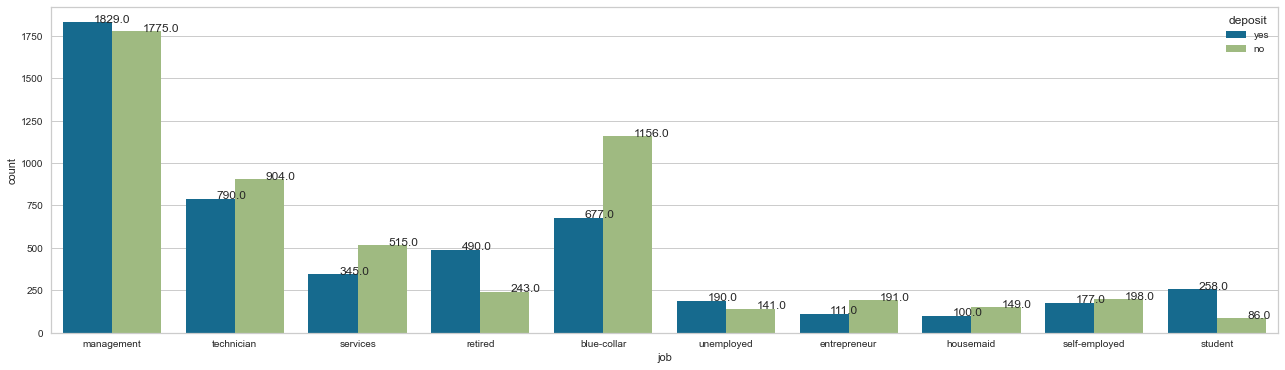

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



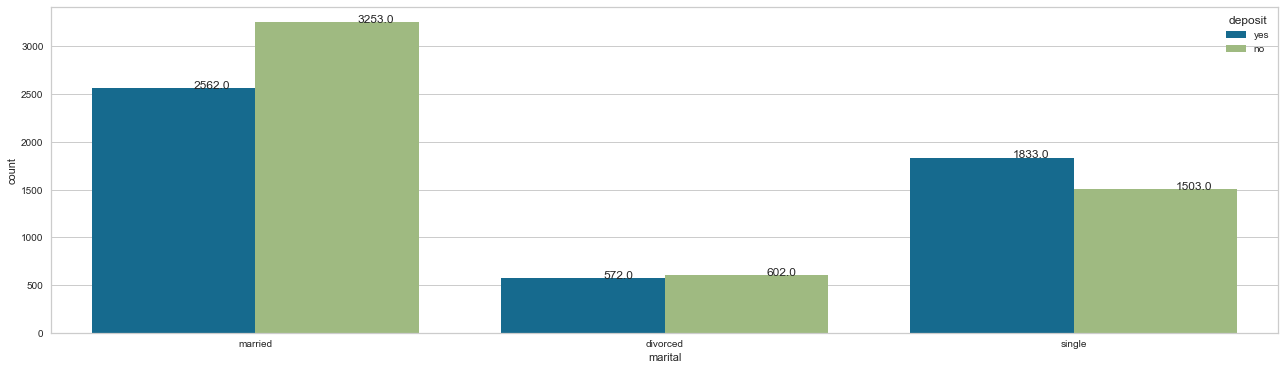

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



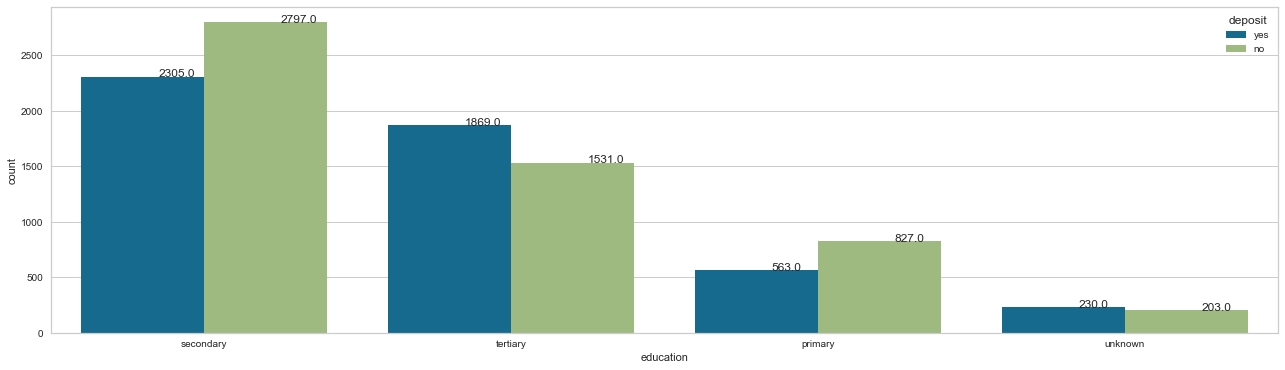

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



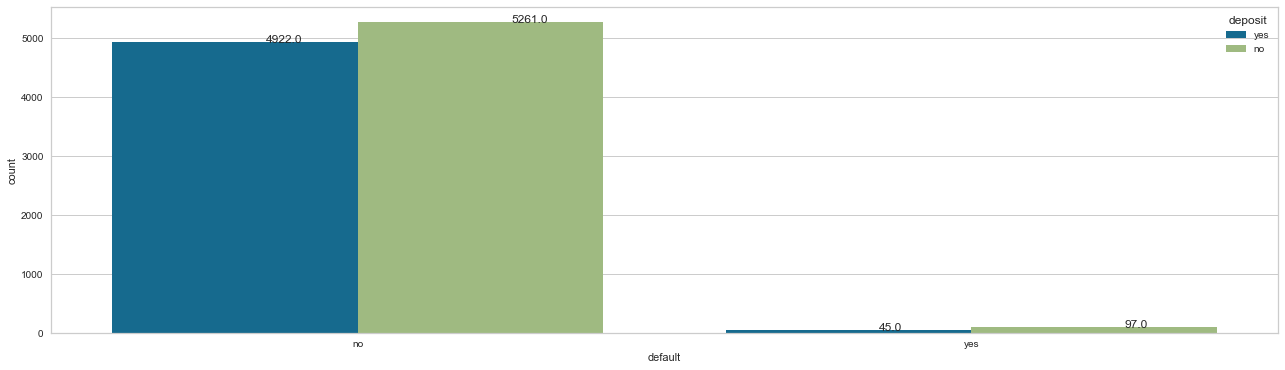

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



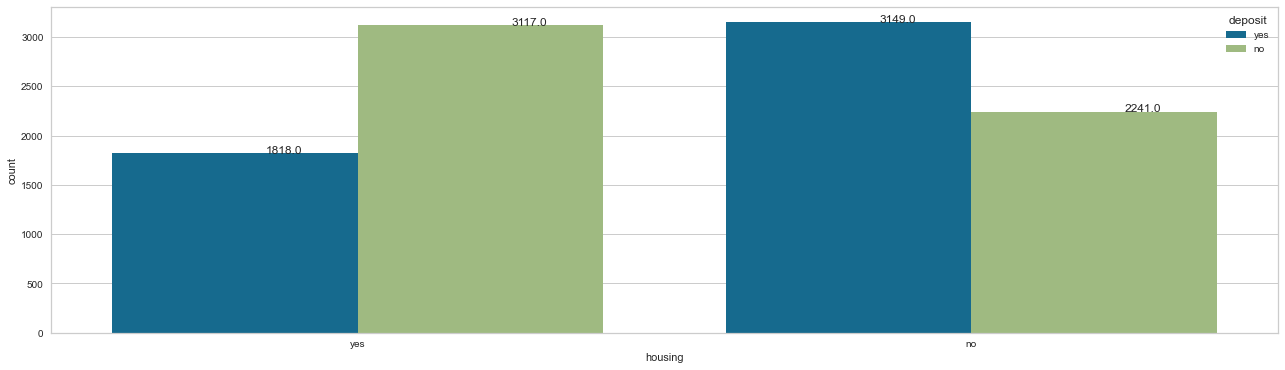

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



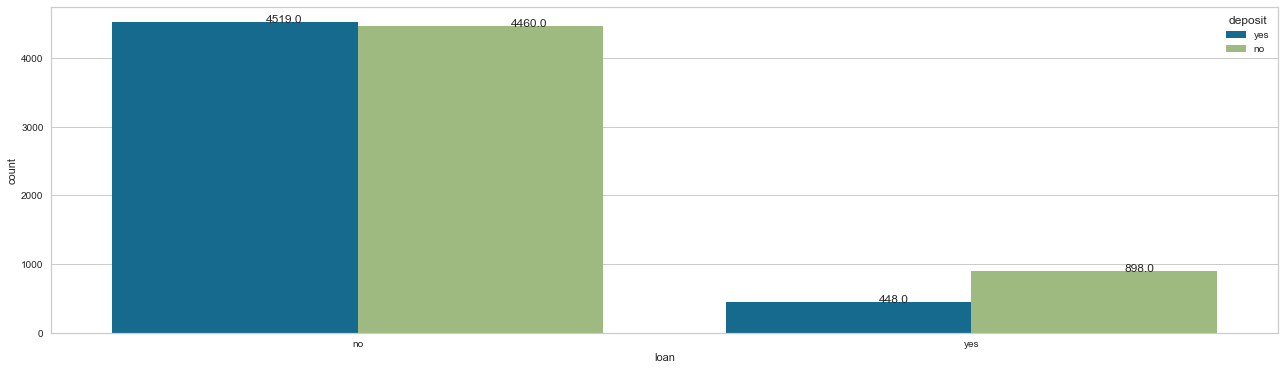

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



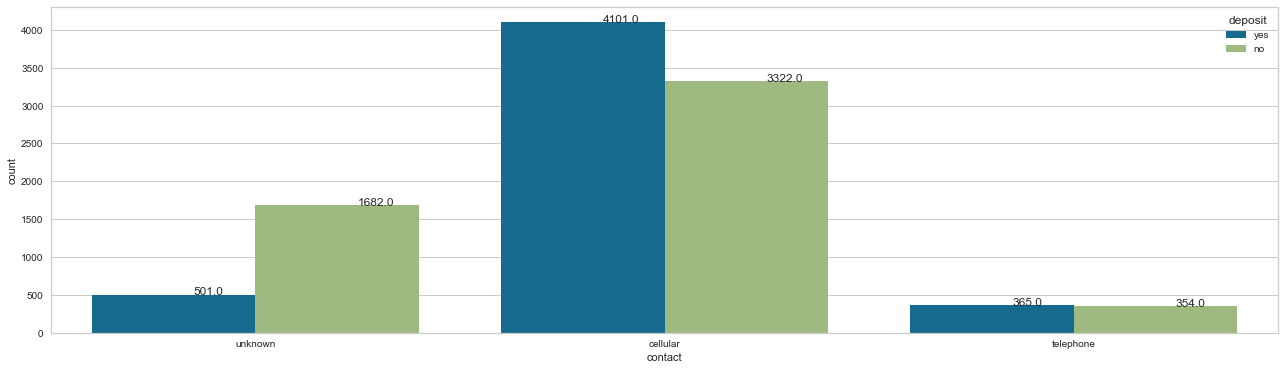

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



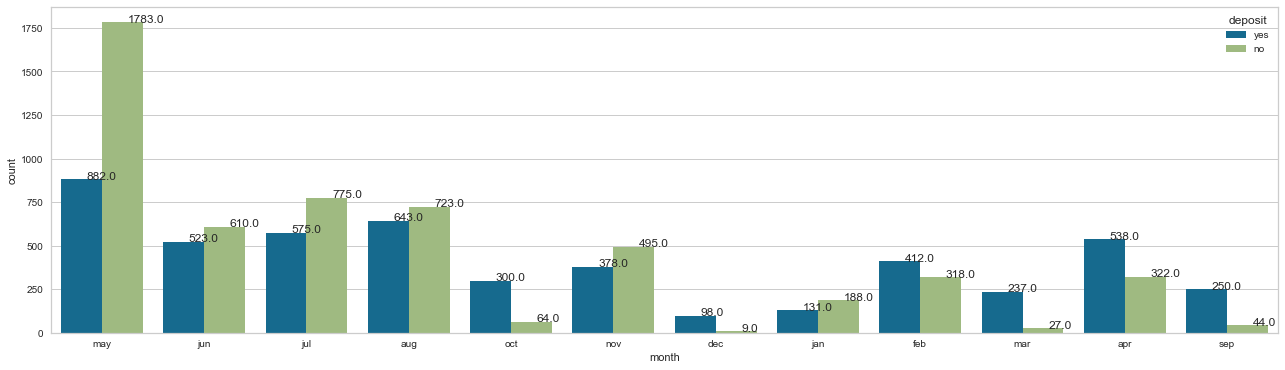

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



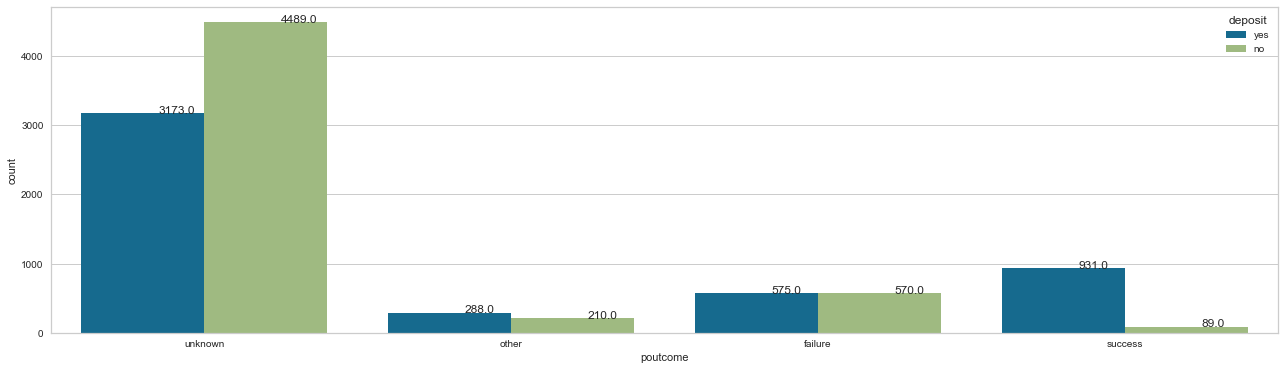

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



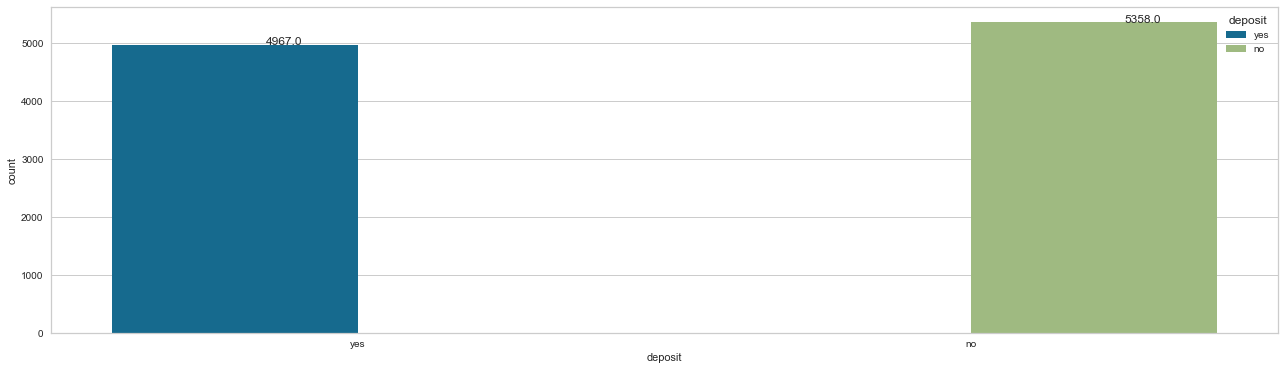

In [25]:
# influence of categorical columns  on response variable 
def categorical_columns(cat_cols):
    for i in cat_cols:
        plt.figure(figsize=(22,6))
        ax = sns.countplot(df[i],hue=df['deposit'])
    
        for p in ax.patches:
           ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.1))
    
        plt.show()
        
categorical_columns(cat_cols)

In [26]:
# influence of numeric columns on response variable
for i in num_cols:
    print(i)
    print(df.groupby('deposit')[i].mean())

age
deposit
no     40.715566
yes    41.522851
Name: age, dtype: float64
balance
deposit
no     1392.032475
yes    1905.950272
Name: balance, dtype: float64
day
deposit
no     16.038447
yes    15.117173
Name: day, dtype: float64
duration
deposit
no     223.843972
yes    535.556674
Name: duration, dtype: float64
campaign
deposit
no     2.807391
yes    2.127441
Name: campaign, dtype: float64
pdays
deposit
no     36.594998
yes    69.048520
Name: pdays, dtype: float64
previous
deposit
no     0.539567
yes    1.177371
Name: previous, dtype: float64


<AxesSubplot:>

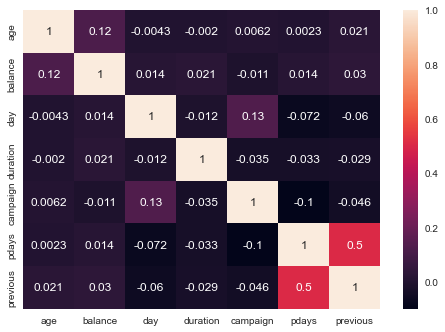

In [27]:
# checking for highly co-related features 
corr = df.corr()
sns.heatmap(corr,annot=True)

# Analysis of the response column

It is very important to look at the response column, which holds the information, which we are going to predict. In our case we should look at 'deposit' column and compare its values to other columns.
First of all we should look at the number of 'yes' and 'no' values in the response column 'deposit'.

<AxesSubplot:title={'center':'Deposit value counts'}>

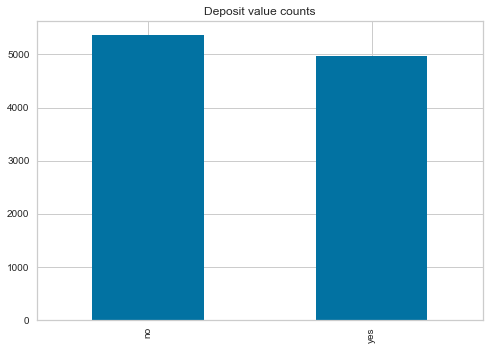

In [28]:
value_counts = df['deposit'].value_counts()

value_counts.plot.bar(title = 'Deposit value counts')

On the diagram we see that counts for 'yes' and 'no' values for 'deposit' are close, so we can use accuracy as a metric for a model, which predicts the campaign outcome.


Let's see how 'deposit' column value varies depending on other categorical columns' values:

<AxesSubplot:title={'center':'Job and deposit'}>

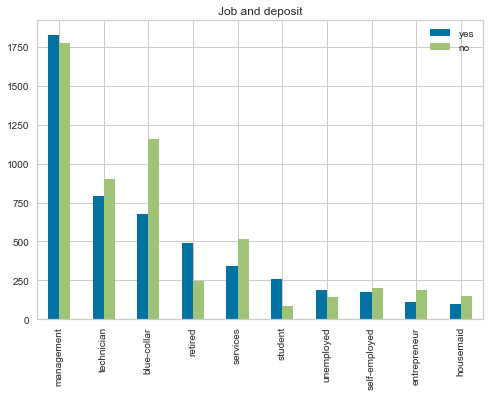

In [29]:
#job and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()

j_df.plot.bar(title = 'Job and deposit')

<AxesSubplot:title={'center':'Marital status and deposit'}>

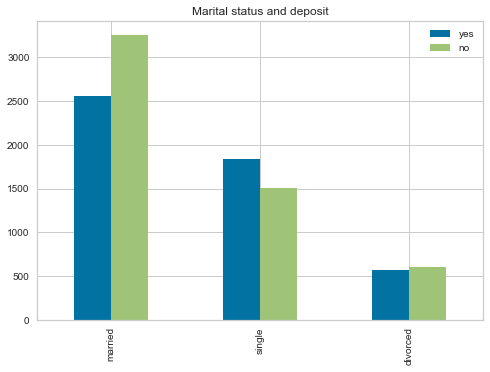

In [30]:
#marital status and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital status and deposit')

<AxesSubplot:title={'center':'Education and deposit'}>

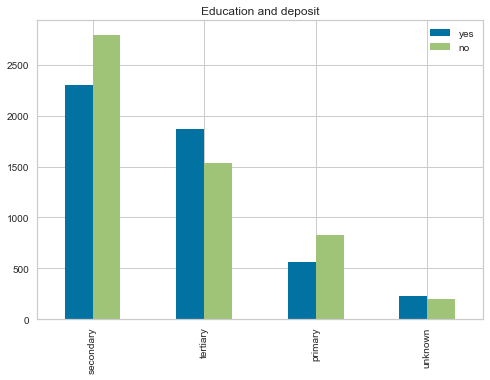

In [31]:
#education and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()

j_df.plot.bar(title = 'Education and deposit')

<AxesSubplot:title={'center':'Type of contact and deposit'}>

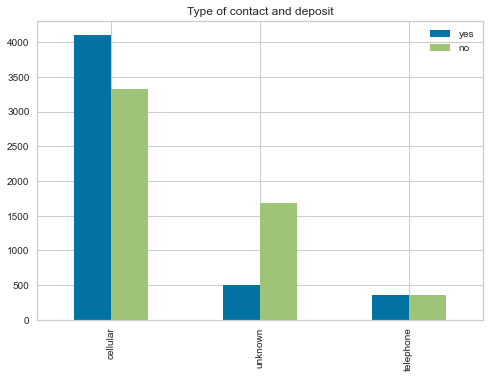

In [32]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['contact'].value_counts()

j_df.plot.bar(title = 'Type of contact and deposit')

Regarding the diagrams we can tell that according to our dataset:

1. Customers with 'blue-collar' and 'services' jobs are less likely to subscribe for term deposit.

2. Married customers are less likely to subscribe for term deposit.

3. Customers with 'cellular' type of contact are less likely to subscribe for term deposit.

Now let's look how numerical columns affect term deposit subscription.

In [33]:
#balance and deposit

b_df = pd.DataFrame()
b_df['balance_yes'] = (df[df['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
b_df['balance_no'] = (df[df['deposit'] == 'no'][['deposit','balance']].describe())['balance']

b_df

,balance_yes,balance_no
count,4967.000000,5358.000000
mean,1905.950272,1392.032475
std,3567.820596,3039.879730
min,-3058.000000,-6847.000000
25%,272.500000,131.000000
50%,834.000000,502.500000
75%,2326.000000,1463.000000
max,81204.000000,66653.000000


<AxesSubplot:title={'center':'Balance and deposit statistics'}>

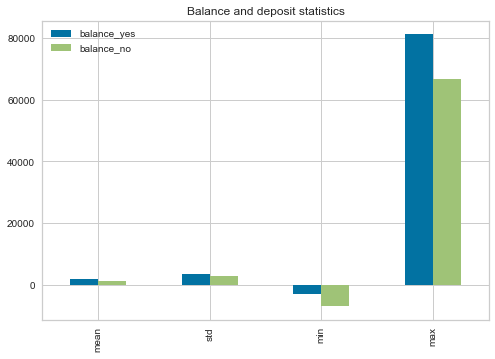

In [34]:
b_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Balance and deposit statistics')

In [35]:
#age and deposit

a_df = pd.DataFrame()
a_df['age_yes'] = (df[df['deposit'] == 'yes'][['deposit','age']].describe())['age']
a_df['age_no'] = (df[df['deposit'] == 'no'][['deposit','age']].describe())['age']

a_df

,age_yes,age_no
count,4967.000000,5358.000000
mean,41.522851,40.715566
std,13.524438,10.310148
min,18.000000,18.000000
25%,31.000000,33.000000
50%,38.000000,39.000000
75%,50.000000,48.000000
max,95.000000,89.000000


<AxesSubplot:title={'center':'Age and deposit statistics'}>

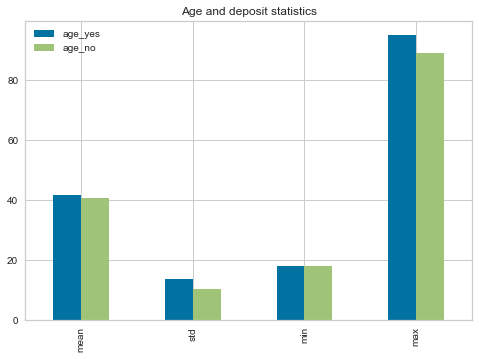

In [36]:
a_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Age and deposit statistics')

In [37]:
#number of contacts performed during this campaign ('campaign') and deposit
c_df = pd.DataFrame()
c_df['campaign_yes'] = (df[df['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
c_df['campaign_no'] = (df[df['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']

c_df

,campaign_yes,campaign_no
count,4967.000000,5358.000000
mean,2.127441,2.807391
std,1.895600,3.169272
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,2.000000,3.000000
max,32.000000,63.000000


<AxesSubplot:title={'center':'Number of contacts performed during this campaign and deposit statistics'}>

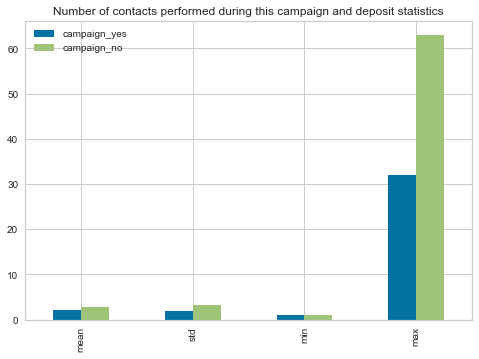

In [38]:
c_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during this campaign and deposit statistics')

In [39]:
#number of contacts performed during previous campaign ('previous') and deposit
p_df = pd.DataFrame()
p_df['previous_yes'] = (df[df['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
p_df['previous_no'] = (df[df['deposit'] == 'no'][['deposit','previous']].describe())['previous']

p_df

,previous_yes,previous_no
count,4967.000000,5358.000000
mean,1.177371,0.539567
std,2.579807,2.020296
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.000000,0.000000
max,58.000000,41.000000


<AxesSubplot:title={'center':'Number of contacts performed during previous campaign and deposit statistics'}>

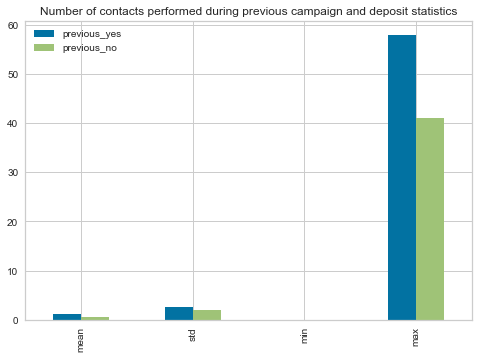

In [40]:
p_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during previous campaign and deposit statistics')

Looking at the diagrams above we can conclude that:

1. People who subscribed for term deposit tend to have greater balance and age values.
2. People who subscribed for term deposit tend to have fewer number of contacts during this campaign.

# Customer Segmentation

In [41]:
df = df.iloc[:,:6]
df.drop("default", axis=1,inplace=True)
df = df[df['balance'] > 0]
df

,age,job,marital,education,balance
0,59,management,married,secondary,2343
1,56,management,married,secondary,45
2,41,technician,married,secondary,1270
3,55,services,married,secondary,2476
4,54,management,married,tertiary,184
...,...,...,...,...,...
11154,52,technician,married,tertiary,523
11155,35,blue-collar,married,secondary,80
11157,33,blue-collar,single,primary,1
11158,39,services,married,secondary,733


In [42]:
df.duplicated().sum()

718

In [43]:
df = df.drop_duplicates()


In [44]:
print("The total number of data-points after removing the rows with duplicated values are:", len(df))

The total number of data-points after removing the rows with duplicated values are: 8919


In [45]:
print("Total categories in the feature Job:\n", df["job"].value_counts(), "\n")
print("Total categories in the feature Education:\n", df["education"].value_counts())

Total categories in the feature Job:
 management       3111
blue-collar      1561
technician       1474
services          748
retired           626
self-employed     331
student           294
unemployed        285
entrepreneur      265
housemaid         224
Name: job, dtype: int64 

Total categories in the feature Education:
 secondary    4389
tertiary     2936
primary      1214
unknown       380
Name: education, dtype: int64


In [46]:
cont_features = []
cat_features = []

for c in df.columns:
    if df[c].dtype == 'int64':
        cont_features += [c]
    else:
        cat_features += [c]

In [47]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[cat_features]))
OH_cols.index = df.index

df_cont = df.drop(cat_features, axis=1)

df_OH = pd.concat([df_cont, OH_cols], axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='balance', ylabel='Density'>

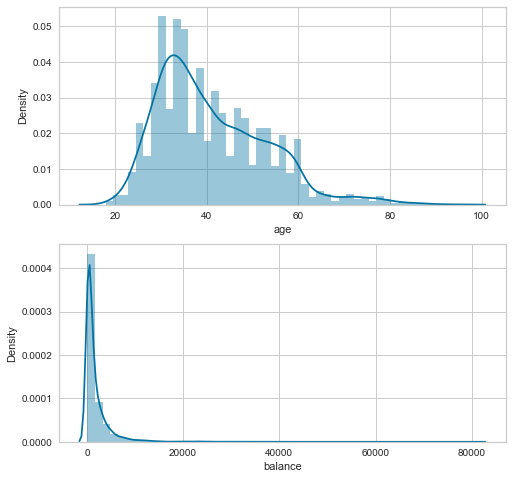

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
sns.distplot(df_OH['age'], ax=ax1)
sns.distplot(df_OH['balance'], ax=ax2)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='balance', ylabel='Density'>

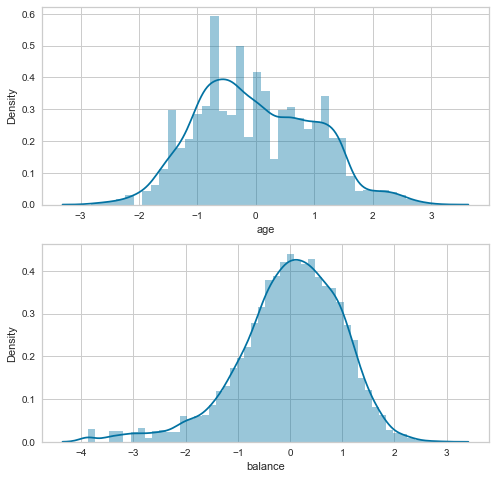

In [49]:
df_OH[cont_features] = np.log(df_OH[cont_features])
scaler = StandardScaler()
df_OH[cont_features] = scaler.fit_transform(df_OH[cont_features])
df[cont_features] = scaler.fit_transform(df[cont_features])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
sns.distplot(df_OH['age'], ax=ax1)
sns.distplot(df_OH['balance'], ax=ax2)

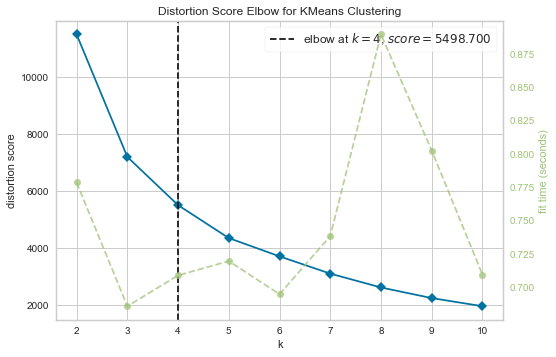

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df[cont_features])
Elbow_M.show()

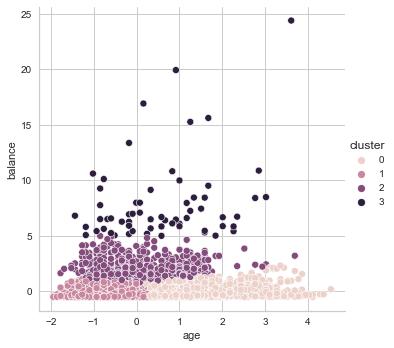

In [51]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0, n_init=30, max_iter=100)
clusters = kmeans.fit_predict(df[cont_features])
df['cluster'] = clusters
sns.relplot(x='age', y='balance', hue='cluster', data=df)

In [52]:
df = pd.read_csv('bank.csv')
df = df.iloc[:,:6]
df.drop("default", axis=1,inplace=True)
df = df[df['balance'] > 0]
df

,age,job,marital,education,balance
0,59,admin.,married,secondary,2343
1,56,admin.,married,secondary,45
2,41,technician,married,secondary,1270
3,55,services,married,secondary,2476
4,54,admin.,married,tertiary,184
...,...,...,...,...,...
11154,52,technician,married,tertiary,523
11155,35,blue-collar,married,secondary,80
11157,33,blue-collar,single,primary,1
11158,39,services,married,secondary,733


In [53]:
df = df.drop_duplicates()


In [54]:
clusters = kmeans.fit_predict(df[cont_features])
df['cluster'] = clusters

In [55]:
groups = df.groupby(['cluster']).agg(['min', 'median', 'mean', 'max', 'sum', 'count']).round()
groups['pct_total'] = (groups['balance']['sum'] / groups['balance']['sum'].sum()).round(3)*100
groups

age                                balance                           \
        min median  mean max     sum count     min   median     mean    max   
cluster                                                                       
0        18   38.0  40.0  95  294255  7267       1    500.0    726.0   2616   
1        20   41.0  44.0  87   64448  1472    2625   4038.0   4509.0   9004   
2        29   52.0  52.0  84    1149    22   26965  33458.0  38908.0  81204   
3        23   42.0  43.0  85    9581   221    9051  12026.0  13548.0  25947   

                       pct_total  
             sum count            
cluster                           
0        5275917  7267      33.5  
1        6637292  1472      42.1  
2         855969    22       5.4  
3        2994059   221      19.0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarni

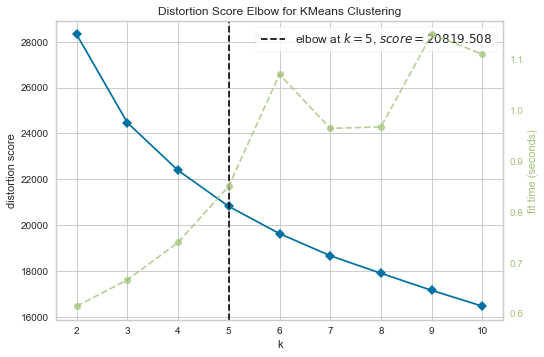

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(df_OH)
Elbow_M.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



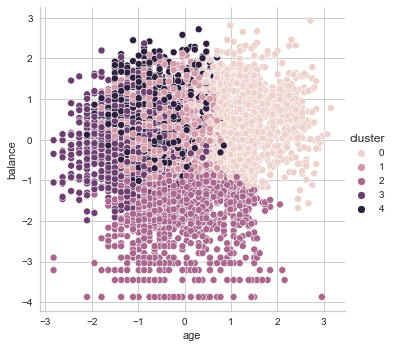

In [57]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=30, max_iter=100, random_state=0)
clusters = kmeans.fit_predict(df_OH)
df_OH['cluster'] = clusters
sns.relplot(x='age', y='balance', hue='cluster', data=df_OH)

In [58]:
df = pd.read_csv('bank.csv')

# Campaign Duration:
1. Campaign Duration: We see that duration has a high correlation with term deposits meaning the higher the duration, the more likely it is for a client to open a term deposit.
2. Average Campaign Duration: The average campaign duration is 374.76, let's see if clients that were above this average were more likely to open a term deposit.
3. Duration Status: People who were above the duration status, were more likely to open a term deposit. 78% of the group that is above average in duration opened term deposits while those that were below average 32% opened term deposit accounts. This tells us that it will be a good idea to target individuals who are in the above average category.

In [59]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


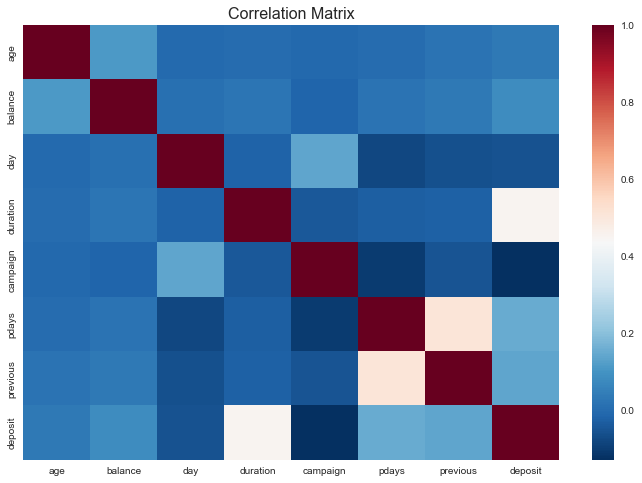

In [60]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
fig = plt.figure(figsize=(12,8))
df['deposit'] = LabelEncoder().fit_transform(df['deposit'])



# Separate both dataframes into 
numeric_df = df.select_dtypes(exclude="object")
# categorical_df = df.select_dtypes(include="object")

corr_numeric = numeric_df.corr()


sns.heatmap(corr_numeric, cbar=True, cmap="RdBu_r")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

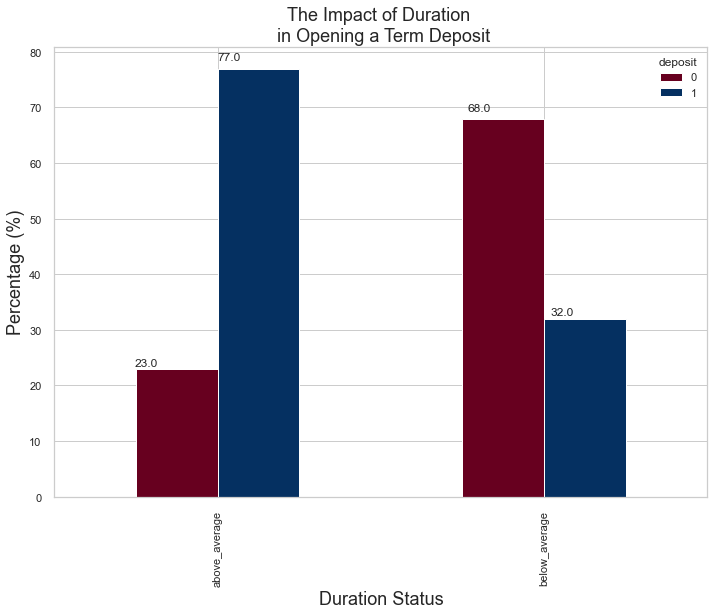

In [61]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
avg_duration = df['duration'].mean()

lst = [df]
df["duration_status"] = np.nan

for col in lst:
    col.loc[col["duration"] < avg_duration, "duration_status"] = "below_average"
    col.loc[col["duration"] > avg_duration, "duration_status"] = "above_average"
    
pct_term = pd.crosstab(df['duration_status'], df['deposit']).apply(lambda r: round(r/r.sum(), 2) * 100, axis=1)

ax = pct_term.plot(kind='bar', stacked=False, cmap='RdBu')
plt.title("The Impact of Duration \n in Opening a Term Deposit", fontsize=18)
plt.xlabel("Duration Status", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))
    

plt.show()

# Classification Model:

In [62]:
term_deposits = df.copy()
dep = term_deposits['deposit']
term_deposits.drop(labels=['deposit'], axis=1,inplace=True)
term_deposits.insert(0, 'deposit', dep)
term_deposits.head()
# housing has a -20% correlation with deposit let's see how it is distributed.
# 52 %
term_deposits["housing"].value_counts()/len(term_deposits)

no     0.526877
yes    0.473123
Name: housing, dtype: float64

In [63]:
term_deposits["loan"].value_counts()/len(term_deposits)

no     0.869199
yes    0.130801
Name: loan, dtype: float64

# Stratified Sampling:
Stratified Sampling: Is an important concept that is often missed when developing a model either for regression or classification. Remember, that in order to avoid overfitting of our data we must implement a cross validation however, we must make sure that at least the features that have the greatest influence on our label (whether a potential client will open a term deposit or not) is equally distributed.

# Personal Loans:
For instance, having a personal loan is an important feature that determines whether a potential client will open a term deposit or not. To confirm it has a heavy weight on the final output you can check the correlation matrix above and you can see it has a -11% correlation with opening a deposit. What steps we should take before implementing stratified sampling in our train and test data?

1. We need to see how our data is distributed.
2. After noticiing that the column of loan contains 87% of "no" (Does not have personal loans) and 13% of "yes" (Have personal loans.)
3. We want to make sure that our training and test set contains the same ratio of 87% "no" and 13% "yes".

In [64]:
from sklearn.model_selection import StratifiedShuffleSplit
# Here we split the data into training and test sets and implement a stratified shuffle split.
stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_set, test_set in stratified.split(term_deposits, term_deposits["loan"]):
    stratified_train = term_deposits.loc[train_set]
    stratified_test = term_deposits.loc[test_set]
    
stratified_train["loan"].value_counts()/len(df)
stratified_test["loan"].value_counts()/len(df)

no     0.173894
yes    0.026160
Name: loan, dtype: float64

In [65]:
train_data = stratified_train # Make a copy of the stratified training set.
test_data = stratified_test
train_data.shape
test_data.shape
train_data['deposit'].value_counts()

0    4697
1    4232
Name: deposit, dtype: int64

In [66]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self
    
    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)
        
        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out
        
        

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [68]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8929 entries, 9867 to 9672
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   deposit          8929 non-null   int32 
 1   age              8929 non-null   int64 
 2   job              8929 non-null   object
 3   marital          8929 non-null   object
 4   education        8929 non-null   object
 5   default          8929 non-null   object
 6   balance          8929 non-null   int64 
 7   housing          8929 non-null   object
 8   loan             8929 non-null   object
 9   contact          8929 non-null   object
 10  day              8929 non-null   int64 
 11  month            8929 non-null   object
 12  duration         8929 non-null   int64 
 13  campaign         8929 non-null   int64 
 14  pdays            8929 non-null   int64 
 15  previous         8929 non-null   int64 
 16  poutcome         8929 non-null   object
 17  duration_status  8929 non-null

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign", "pdays", "previous","duration"])),
    ("std_scaler", StandardScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month",
                                     "poutcome"])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

In [70]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

C:\Users\Qwerty\AppData\Local\Temp/ipykernel_10008/4214550450.py:39: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Qwerty\AppData\Local\Temp/ipykernel_10008/4214550450.py:74: DeprecationWarning:

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\Qwerty\AppData\Local\Temp/ipykernel_10008/4214550450.py:76: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When 

array([[ 1.14643868,  1.68761105,  1.69442818, ...,  0.        ,
         0.        ,  1.        ],
       [-0.86102339, -0.35066205, -0.5560058 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.94466765, -0.20504785,  0.39154535, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.86102339, -0.26889658, -1.02978138, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2263519 , -0.32166951,  0.50998924, ...,  0.        ,
         0.        ,  1.        ],
       [-0.61009063, -0.34740446,  1.69442818, ...,  1.        ,
         0.        ,  0.        ]])

In [71]:
y_train = train_data['deposit']
y_test = test_data['deposit']
y_train.shape

(8929,)

In [72]:
from sklearn.preprocessing import LabelEncoder

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)
y_train_yes = (y_train == 1)
y_train
y_train_yes


array([False, False,  True, ...,  True,  True, False])

In [73]:
some_instance = X_train[1250]

In [74]:
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


dict_classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=18),
    "Neural Net": MLPClassifier(alpha=1),
    "Naive Bayes": GaussianNB()
}

In [75]:
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, Y_train, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,3)), columns = ['classifier', 'train_score', 'training_time'])
    count = 0
    for key, classifier in dict_classifiers.items():
        t_start = time.process_time()
        classifier.fit(X_train, Y_train)
        t_end = time.process_time()
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        df_results.loc[count,'classifier'] = key
        df_results.loc[count,'train_score'] = train_score
        df_results.loc[count,'training_time'] = t_diff
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_diff))
        count+=1
    return df_results

In [76]:
df_results = batch_classify(X_train, y_train)
print(df_results.sort_values(by='train_score', ascending=False))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



trained Logistic Regression in 0.50 s
trained Nearest Neighbors in 0.06 s
trained Linear SVM in 3.80 s
trained Gradient Boosting Classifier in 3.78 s
trained Decision Tree in 0.12 s
trained Random Forest in 0.30 s
trained Neural Net in 30.67 s
trained Naive Bayes in 0.09 s
                     classifier  train_score  training_time
4                 Decision Tree     1.000000       0.125000
5                 Random Forest     0.997200       0.296875
2                    Linear SVM     0.881958       3.796875
1             Nearest Neighbors     0.863255       0.062500
3  Gradient Boosting Classifier     0.861463       3.781250
6                    Neural Net     0.856535      30.671875
0           Logistic Regression     0.830776       0.500000
7                   Naive Bayes     0.721693       0.093750


In [77]:
# Use Cross-validation.
from sklearn.model_selection import cross_val_score

# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, cv=3)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = tree.DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3)
rand_mean = rand_scores.mean()

# NeuralNet Classifier
neural_clf = MLPClassifier(alpha=1)
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3)
neural_mean = neural_scores.mean()

# Naives Bayes
nav_clf = GaussianNB()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3)
nav_mean = neural_scores.mean()

d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean]}

result_df = pd.DataFrame(data=d)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [78]:
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

,Classifiers,Crossval Mean Scores
1,SVC,0.851831
6,Neural Classifier,0.847239
7,Naives Bayes,0.847239
4,Grad B CLF,0.844552
5,Rand FC,0.840968
0,Logistic Reg.,0.828536
2,KNN,0.804569
3,Dec Tree,0.783850


In [79]:
variables_selected = [
    'age',
    'job',
    'marital',
    'education',
    'default',
    'balance',
    'housing',
    'loan',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'deposit', # target variable
]


In [80]:
df_final = df[variables_selected]

In [81]:
df_final.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [82]:
# One-hot (creating dummies for categorical variables)
df_final = pd.get_dummies(df_final, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'])

In [83]:
df_final.head()

,age,balance,day,duration,campaign,pdays,previous,deposit,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343,5,1042,1,-1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
1,56,45,5,1467,1,-1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
2,41,1270,5,1389,1,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,55,2476,5,579,1,-1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,54,184,5,673,2,-1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1


# WITHOUT PCA

In [84]:
y = df_final.deposit
X = df_final.drop('deposit', axis=1)

In [85]:
y.shape, X.shape

((11162,), (11162, 51))

In [86]:
# Normalization of data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [87]:
df_X_norm = pd.DataFrame(X_norm)

In [88]:
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics
from sklearn.model_selection import  GridSearchCV
from sklearn import model_selection
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

In [89]:
seed = 123
k = 10

kfolds = model_selection.KFold(n_splits=k, shuffle = True, random_state=seed)

In [90]:
KNN = KNeighborsClassifier()

params = {
    'n_neighbors' : list(range(2,40)),
    'weights' : ['distance'],
    'algorithm' : ['kd_tree']
}

grid_knn = GridSearchCV(KNN, param_grid=params, cv = kfolds)
grid_knn.fit(X_norm, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['kd_tree'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...],
                         'weights': ['distance']})

In [91]:
print(grid_knn.best_score_)
print(grid_knn.best_params_)

0.7418030406587024
{'algorithm': 'kd_tree', 'n_neighbors': 31, 'weights': 'distance'}


In [92]:
DT = DecisionTreeClassifier()

params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : list(range(2, 15)),
}

grid_dt = GridSearchCV(DT, param_grid=params, cv=kfolds)
grid_dt.fit(X_norm, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14]})

In [93]:
print(grid_dt.best_score_)
print(grid_dt.best_params_)

0.8189391386939542
{'criterion': 'gini', 'max_depth': 9}


In [94]:
### Logistic regression

LR = LogisticRegression()

params = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 100),
    'solver' : ['liblinear']
}

grid_lr = GridSearchCV(LR, param_grid=params, cv = kfolds)
grid_lr.fit(X_norm, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.6297...
       1.38488637e+02, 1.66810054e+02, 2.00923300e+02, 2.42012826e+02,
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [95]:
print(grid_lr.best_score_)
print(grid_lr.best_params_)

0.8257494151962342
{'C': 4.862601580065354, 'penalty': 'l1', 'solver': 'liblinear'}


In [96]:
### Random Forest

RF = RandomForestClassifier()

params = {
    "n_estimators": np.array([50, 100, 200, 300]), 
    "max_depth": [3, 6, 9, 12, 15, 18, 21],
}

grid_rf = GridSearchCV(RF, param_grid=params, cv = kfolds)
grid_rf.fit(X_norm, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6, 9, 12, 15, 18, 21],
                         'n_estimators': array([ 50, 100, 200, 300])})

In [97]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.8572826118346955
{'max_depth': 18, 'n_estimators': 200}


In [98]:
### XG Boost

xgb = XGBClassifier(verbosity = 0) # verbosity = 0 : to hide warnings

params = {
    'max_depth': [6, 9, 11, 13, 16, 19, 22], 
    'n_estimators': [100],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_xgb = GridSearchCV(xgb, param_grid=params, cv = kfolds)
grid_xgb.fit(X_norm, y)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_wei...None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=0),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [6, 9, 11, 13, 16, 19, 22],
                         'n_estimators': [100]})

In [99]:
print(grid_xgb.best_score_)
print(grid_xgb.best_params_)

0.8627489627554606
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


In [ ]:
### SVM

svm = SVC()

params = {
    "C": [0.001, 0.01, 0.1, 1.],
    "kernel": ["linear", "poly", "rbf"],
    "gamma": ["scale", "auto"], 
}

grid_svm = GridSearchCV(svm, param_grid=params, cv = kfolds)
grid_svm.fit(X_norm, y)

In [ ]:
print(grid_svm.best_score_)
print(grid_svm.best_params_)

# Modeling with Principal Component "PC1"

In [ ]:
variables_selected = [
    'age',
    'job.rev', # categories reduced
    'marital',
    'education',
    'default',
    'balance',
    'housing',
    'loan',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    #'pdays', # excluded
    #'previous', # excluded
    'PC1', # included
    'poutcome',
    'deposit', # target variable
]

In [ ]:
df_final = df_all[variables_selected]

In [ ]:
# One-hot (creating dummies for categorical variables)
df_final = pd.get_dummies(df_final, columns=['job.rev', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'])

In [ ]:
y = df_final.deposit
X = df_final.drop('deposit', axis=1)

In [ ]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [ ]:
df_X_norm = pd.DataFrame(X_norm)

In [ ]:
KNN = KNeighborsClassifier()

params = {
    'n_neighbors' : list(range(2,40)),
    'weights' : ['distance'],
    'algorithm' : ['kd_tree']
}

grid_knn = GridSearchCV(KNN, param_grid=params, cv = kfolds)
grid_knn.fit(X_norm, y)

In [ ]:
print(grid_knn.best_score_)
print(grid_knn.best_params_)

In [ ]:
#### Decision Tree

DT = DecisionTreeClassifier()

params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : list(range(2, 15)),
}

grid_dt = GridSearchCV(DT, param_grid=params, cv=kfolds)
grid_dt.fit(X_norm, y)

In [ ]:
print(grid_dt.best_score_)
print(grid_dt.best_params_)

In [ ]:
### Logistic regression

LR = LogisticRegression()

params = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 100),
    'solver' : ['liblinear']
}

grid_lr = GridSearchCV(LR, param_grid=params, cv = kfolds)
grid_lr.fit(X_norm, y)

In [ ]:
print(grid_lr.best_score_)
print(grid_lr.best_params_)

In [ ]:
### Random Forest

RF = RandomForestClassifier()

params = {
    "n_estimators": np.array([50, 100, 200, 300]), 
    "max_depth": [3, 6, 9, 12, 15, 18, 21],
}

grid_rf = GridSearchCV(RF, param_grid=params, cv = kfolds)
grid_rf.fit(X_norm, y)

In [ ]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)

In [ ]:
### XG Boost

xgb = XGBClassifier(verbosity = 0) # verbosity = 0 : to hide warnings

params = {
    'max_depth': [6, 9, 11, 13, 16, 19, 22], 
    'n_estimators': [100],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_xgb = GridSearchCV(xgb, param_grid=params, cv = kfolds)
grid_xgb.fit(X_norm, y)

In [ ]:
print(grid_xgb.best_score_)
print(grid_xgb.best_params_)

In [ ]:
svm = SVC()

params = {
    "C": [0.001, 0.01, 0.1, 1.],
    "kernel": ["linear", "poly", "rbf"], 
    "gamma": ["scale", "auto"],
}

grid_svm = GridSearchCV(svm, param_grid=params, cv = kfolds)
grid_svm.fit(X_norm, y)

In [ ]:
print(grid_svm.best_score_)
print(grid_svm.best_params_)

# Conclusion
Key outcomes of the analysis are the recommendations for future marketing campaigns:

The customer's account balance has a huge influence on the campaign's outcome. People with account balance above 1490$ are more likely to subscribe for term deposit, so future address those customers.
The customer's age affects campaign outcome as well. Future campains should concentrate on customers from age categories below 30 years old and above 50 years old.
Number of contacts with the customer during the campaign is also very important. The number of contacts with the customer shouldn't exceed 4